In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import datetime
import os
import gc

In [2]:
df_train = pd.read_csv('data/train.csv')

In [3]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
targets= df_train.target

In [5]:
filenames = ['data/jpeg/train/' + fname + '.jpg' for fname in df_train.image_name]

In [6]:
X = filenames
y = pd.get_dummies(targets)

In [7]:
# Set number of images to use for experimenting
First_Image = 0
Last_Image = 300

In [8]:
x_train, x_val, y_train, y_val = train_test_split(X[:], y[:], test_size = 0.2, random_state = 42)

In [9]:
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [10]:
def create_df(image, target):
    image = process_image(image)
    return image, target

In [11]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train), tf.constant(y_train)))
train_data = train_data.map(create_df).batch(BATCH_SIZE).shuffle(buffer_size=len(x_train))

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_val), tf.constant(y_val)))
val_data = val_data.map(create_df).batch(BATCH_SIZE)

In [13]:
INPUT_SIZE = [None, IMG_SIZE,IMG_SIZE, 3]
HIDDEN_SIZE1 = 256
HIDDEN_SIZE2 = 128
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2

In [14]:
Total_num_img = len(df_train)
Num_mlg = np.count_nonzero(df_train.target)
Num_bng = Total_num_img - Num_mlg

In [15]:
Weight_bng = 1/Num_bng * Total_num_img/2
Weight_mlg = 1/Num_mlg * Total_num_img/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

In [16]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [25]:
def create_model(retrain = False):
    model = []
    if retrain:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key=os.path.getctime)
        model = load_model(model_path)
        model.summary()
    else:
        model = Sequential([
                    Conv2D(64, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),

                    Conv2D(128, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),
                    
                    Conv2D(256, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),
                    
                    Flatten(),
                    Dense(HIDDEN_SIZE,activation='relu'),
                    Dense(OUTPUT_SIZE, activation='softmax')])

        model.build(INPUT_SIZE)

        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-2),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [tf.keras.metrics.AUC()])

        model.summary()
    return model

In [26]:
model = create_model(False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  819456    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                 

In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [29]:
tensorboard = create_tensorboard_callback()

In [30]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)
Rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', cooldown=0, min_lr=0)

In [31]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
gc.collect()

2566

In [24]:
history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=[EarlyStopping, Rate,tensorboard], class_weight = class_weights)

Epoch 1/100


ValueError: in user code:

    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:543 train_step  **
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:391 update_state
        self._build(y_pred, y_true)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:322 _build
        self._metrics, y_true, y_pred)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1118 map_structure_up_to
        **kwargs)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1214 map_structure_with_tuple_paths_up_to
        *flat_value_lists)]
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1213 <listcomp>
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1116 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:421 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:421 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:440 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:3358 get
        return deserialize(str(identifier))
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:3349 deserialize
        printable_module_name='metric function')
    C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:392 deserialize_keras_object
        raise ValueError('Unknown ' + printable_module_name + ':' + object_name)

    ValueError: Unknown metric function:val_AUC


In [77]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-07-02 22:05:39.139110: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-07-02 22:05:39.141099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "c:\users\user\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\user\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\anaconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\user\anaconda3\lib\site-packages\tensorboard\main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\user\anaconda3\lib\site-packages\absl\app.py", line 299, in run
    _run_main(main, ar

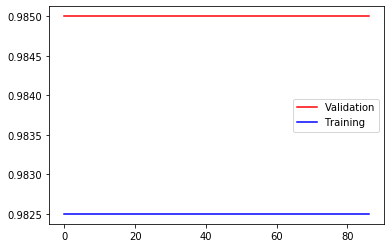

In [75]:
plt.plot(history.history['val_accuracy'], color = 'red')
plt.plot(history.history['accuracy'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.show()

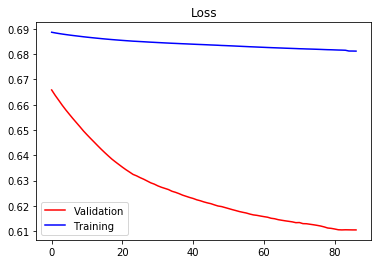

In [76]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

In [49]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [50]:
sfx = "Images {}_{}_CNN".format(First_Image, Last_Image)
save_model(model, suffix=sfx)

Saving model to: models\20200702060005-Images 0_30000_DNN.h5...


'models\\20200702060005-Images 0_30000_DNN.h5'